***
# COVID-19 Vaccination Progress
****

## Dataset Overview

+ Country - this is the country for which the vaccination information is provided
+ Country ISO Code - ISO code for the country;
+ Date- date for the data entry; for some of the dates we have only the daily vaccinations, for others, only the (cumulative) total;
+ Total number of vaccin ations - this is the absolute number of total immunizations in the country;
+ Total number of people vaccinated - a person, depending on the immunization scheme, will receive one or more (typically 2) vaccines; at a certain moment, the number of vaccination might be larger than the number of people;
+ Total number of people fully vaccinated - this is the number of people that received the entire set of immunization according to the immunization scheme (typically 2); at a certain moment in time, there might be a certain number of people that received one vaccine and another number (smaller) of people that received all vaccines in the scheme;
+ Daily vaccinations (raw) - for a certain data entry, the number of vaccination for that date/country; ONLY CHANGE COMPARED TO PREVIOUS DAY!!!
+ Daily vaccinations - for a certain data entry, the number of vaccination for that date/country;
+ Total vaccinations per hundred - ratio (in percent) between vaccination number and total population up to the date in the country;
+ Total number of people vaccinated per hundred - ratio (in percent) between population immunized and total population up to the date in the country;
+ Total number of people fully vaccinated per hundred - ratio (in percent) between population fully immunized and total population up to the date in the country;
+ Number of vaccinations per day - number of daily vaccination for that day and country;
+ Daily vaccinations per million - ratio (in ppm) between vaccination number and total population for the current date in the country;
+ Vaccines used in the country - total number of vaccines used in the country (up to date);
+ Source name - source of the information (national authority, international organization, local organization etc.);
+ Source website - website of the source of information;

In [1]:
#common imports:
import numpy as np
import pandas as pd
from datetime import datetime
import os
import matplotlib.dates as md

#import for visualization
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
#for Worldmap
#import shapefile as shp


#for timeseries:
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.ndimage import gaussian_filter


from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller,kpss

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf



#from wordcloud import WordCloud
from pandas_profiling import ProfileReport

sns.set(rc={'figure.figsize':(20,15)})


#suppress pandas future warnings:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


## First Data overview

In [2]:
#import dataset country_vaccinations:
df = pd.read_csv('data/country_vaccinations.csv')

In [3]:
#first check:
df.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Oxford/AstraZeneca,Government of Afghanistan,http://www.xinhuanet.com/english/asiapacific/2...
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,http://www.xinhuanet.com/english/asiapacific/2...
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,http://www.xinhuanet.com/english/asiapacific/2...
3,Afghanistan,AFG,2021-02-25,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,http://www.xinhuanet.com/english/asiapacific/2...
4,Afghanistan,AFG,2021-02-26,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,http://www.xinhuanet.com/english/asiapacific/2...


In [4]:
df.tail()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
8074,Zimbabwe,ZWE,2021-03-20,42210.0,42210.0,NaN,523.0,836.0,0.28,0.28,NaN,56.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1374795915...
8075,Zimbabwe,ZWE,2021-03-21,42729.0,42729.0,NaN,519.0,910.0,0.29,0.29,NaN,61.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1374795915...
8076,Zimbabwe,ZWE,2021-03-22,43294.0,43294.0,NaN,565.0,805.0,0.29,0.29,NaN,54.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1374795915...
8077,Zimbabwe,ZWE,2021-03-23,44135.0,44135.0,NaN,841.0,655.0,0.30,0.30,NaN,44.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1374795915...
8078,Zimbabwe,ZWE,2021-03-24,49404.0,49404.0,NaN,5269.0,1400.0,0.33,0.33,NaN,94.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1374795915...


Cleaning tasks:
- First check of data shows a lot missing values. 

In [5]:
#Number of columns and rows:
shape1 = df.shape
print(f'We have {shape1[1]} columns and {shape1[0]} rows in our dataset.')

We have 15 columns and 8079 rows in our dataset.


In [6]:
#Information about datatypes per column:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8079 entries, 0 to 8078
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   country                              8079 non-null   object 
 1   iso_code                             8079 non-null   object 
 2   date                                 8079 non-null   object 
 3   total_vaccinations                   4984 non-null   float64
 4   people_vaccinated                    4423 non-null   float64
 5   people_fully_vaccinated              3021 non-null   float64
 6   daily_vaccinations_raw               4192 non-null   float64
 7   daily_vaccinations                   7891 non-null   float64
 8   total_vaccinations_per_hundred       4984 non-null   float64
 9   people_vaccinated_per_hundred        4423 non-null   float64
 10  people_fully_vaccinated_per_hundred  3021 non-null   float64
 11  daily_vaccinations_per_million

Cleaning task: 
- change object to datetime for column date
- Check missing values in all columns with rows less than 8079

In [7]:
df.nunique()

country                                 151
iso_code                                151
date                                    102
total_vaccinations                     4784
people_vaccinated                      4253
people_fully_vaccinated                2880
daily_vaccinations_raw                 3868
daily_vaccinations                     5563
total_vaccinations_per_hundred         1955
people_vaccinated_per_hundred          1663
people_fully_vaccinated_per_hundred     818
daily_vaccinations_per_million         3698
vaccines                                 26
source_name                              92
source_website                          147
dtype: int64

In [8]:
#basic statistic
df.describe().transpose().round()

,count,mean,std,min,25%,50%,75%,max
total_vaccinations,4984.0,2597915.0,9383280.0,0.0,40452.0,276962.0,1303350.0,130473853.0
people_vaccinated,4423.0,2073454.0,6824277.0,0.0,36780.0,249555.0,1007708.0,85472166.0
people_fully_vaccinated,3021.0,893378.0,3595095.0,1.0,19019.0,111716.0,488937.0,46365515.0
daily_vaccinations_raw,4192.0,92034.0,289560.0,0.0,2738.0,13838.0,56702.0,4575496.0
daily_vaccinations,7891.0,60968.0,213914.0,1.0,1026.0,6161.0,27794.0,2541597.0
total_vaccinations_per_hundred,4984.0,10.0,18.0,0.0,1.0,4.0,11.0,162.0
people_vaccinated_per_hundred,4423.0,8.0,12.0,0.0,1.0,3.0,9.0,90.0
people_fully_vaccinated_per_hundred,3021.0,4.0,8.0,0.0,0.0,2.0,3.0,72.0
daily_vaccinations_per_million,7891.0,2699.0,4163.0,0.0,363.0,1305.0,3211.0,54264.0


What we can see from the describtion:
- we have a huge range from min to max for the various vaccination columns.
- People fully vaccinated per hundred shows very few countries already vaccinated a high number of their citizens but 75% are only at 3% or less.

## Data cleaning

In [9]:
#check for missing values
missing_values = pd.DataFrame(df.isnull().sum(), columns=['ID'])
missing_values

,ID
country,0
iso_code,0
date,0
total_vaccinations,3095
people_vaccinated,3656
people_fully_vaccinated,5058
daily_vaccinations_raw,3887
daily_vaccinations,188
total_vaccinations_per_hundred,3095
people_vaccinated_per_hundred,3656


In [10]:
#check for missing values in %
round(100*(df.isnull().sum()/len(df.index)),0)

country                                 0.0
iso_code                                0.0
date                                    0.0
total_vaccinations                     38.0
people_vaccinated                      45.0
people_fully_vaccinated                63.0
daily_vaccinations_raw                 48.0
daily_vaccinations                      2.0
total_vaccinations_per_hundred         38.0
people_vaccinated_per_hundred          45.0
people_fully_vaccinated_per_hundred    63.0
daily_vaccinations_per_million          2.0
vaccines                                0.0
source_name                             0.0
source_website                          0.0
dtype: float64

We have a high percentage of missing values in the vaccine columns.

In [11]:
# generate count statistics of duplicate entries
if len(df[df.duplicated()]) > 0:
    print("No. of duplicated entries: ", len(df[df.duplicated()]))
    print(df[df.duplicated(keep=False)].sort_values(by=list(df.columns)).head())
else:
    print("No duplicated entries found")

No duplicated entries found


Data cleaning tasks:
- countries have different names (e.g. England, United Kingdom, Northern Ireland, Wales, Scotland)
- drop daily_vaccinations_raw
(set categorical data to categorical data tpye)

## Data cleaning - Nan

We have a lot of missing data and handle it as follows:

- First we drop all rows with only Nans/0.0 for all vaccination columns. In these cases only the vaccines have been reported but vaccinations started later. This correction eliminanted the 2% missing data for daily vaccinations. 

- people_fully_vaccinated/peple_fully_vaccinated_per_hundred: fill NaNs with 0 as these are missing values because no one is fully vaccinated at that time.

- For total_vaccinations 39% for the data are missing. This is surprising as values for daily_vaccinations are fully available. A comparison of total_vaccinations at 24.03.2021 and the summed up daily_vaccinations showed a big difference (e.g. for the US over 7.0 M less reported doses for daily_vaccinations as for total_vaccination. A further analysis where the data originally came from leads to the following explanation:

"New doses administered per day (7-day smoothed). For countries that don't report data on a daily basis, we assume that doses changed equally on a daily basis over any periods in which no data was reported. This produces a complete series of daily figures, which is then averaged over a rolling 7-day window."(source: Our World in Data)

- noch begründen warum wir nicht totals berechnen (weil eh schon smoothed..), aber beides nutzen (totals am 24.03 vorhanden)


In [12]:
#copy dataset before cleaning
df1 = df.copy()

In [13]:
#change type for date to datetime
df1['date'] = pd.to_datetime(df1['date'])
df1.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Oxford/AstraZeneca,Government of Afghanistan,http://www.xinhuanet.com/english/asiapacific/2...
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,http://www.xinhuanet.com/english/asiapacific/2...
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,http://www.xinhuanet.com/english/asiapacific/2...
3,Afghanistan,AFG,2021-02-25,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,http://www.xinhuanet.com/english/asiapacific/2...
4,Afghanistan,AFG,2021-02-26,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,http://www.xinhuanet.com/english/asiapacific/2...


In [14]:
#test changes to date
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8079 entries, 0 to 8078
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   country                              8079 non-null   object        
 1   iso_code                             8079 non-null   object        
 2   date                                 8079 non-null   datetime64[ns]
 3   total_vaccinations                   4984 non-null   float64       
 4   people_vaccinated                    4423 non-null   float64       
 5   people_fully_vaccinated              3021 non-null   float64       
 6   daily_vaccinations_raw               4192 non-null   float64       
 7   daily_vaccinations                   7891 non-null   float64       
 8   total_vaccinations_per_hundred       4984 non-null   float64       
 9   people_vaccinated_per_hundred        4423 non-null   float64       
 10  people_fully

In [15]:
# drop all rows with NaNs in 'people_fully_vaccinated', 'daily_vaccinations', 'daily_vaccinations_per_million':
df1.dropna(subset = ['people_fully_vaccinated', 'daily_vaccinations', 'daily_vaccinations_per_million'], axis = 0, how = 'all', inplace = True)


In [16]:
#Fill all NaNs for people fully vaccinated and people fully vaccinated per hundred with 0:
df1['people_fully_vaccinated'] = df1['people_fully_vaccinated'].fillna(0)
df1['people_fully_vaccinated_per_hundred'] = df1['people_fully_vaccinated_per_hundred'].fillna(0)

In [17]:
#check for missing data in 
round(100*(df1.isnull().sum()/len(df1.index)),0)

country                                 0.0
iso_code                                0.0
date                                    0.0
total_vaccinations                     39.0
people_vaccinated                      46.0
people_fully_vaccinated                 0.0
daily_vaccinations_raw                 47.0
daily_vaccinations                      0.0
total_vaccinations_per_hundred         39.0
people_vaccinated_per_hundred          46.0
people_fully_vaccinated_per_hundred     0.0
daily_vaccinations_per_million          0.0
vaccines                                0.0
source_name                             0.0
source_website                          0.0
dtype: float64

In [18]:
df1_corr = df1.copy()

In [19]:
df1[df1['country']== 'Israel']

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
3689,Israel,ISR,2020-12-20,7401.0,7401.0,0.0,7340.0,7340.0,0.09,0.09,0.00,848.0,"Moderna, Pfizer/BioNTech",Government of Israel,https://datadashboard.health.gov.il/COVID-19/g...
3690,Israel,ISR,2020-12-21,32186.0,32186.0,0.0,24785.0,16062.0,0.37,0.37,0.00,1856.0,"Moderna, Pfizer/BioNTech",Government of Israel,https://datadashboard.health.gov.il/COVID-19/g...
3691,Israel,ISR,2020-12-22,76719.0,76719.0,0.0,44533.0,25553.0,0.89,0.89,0.00,2952.0,"Moderna, Pfizer/BioNTech",Government of Israel,https://datadashboard.health.gov.il/COVID-19/g...
3692,Israel,ISR,2020-12-23,139255.0,139255.0,0.0,62536.0,34798.0,1.61,1.61,0.00,4020.0,"Moderna, Pfizer/BioNTech",Government of Israel,https://datadashboard.health.gov.il/COVID-19/g...
3693,Israel,ISR,2020-12-24,212498.0,212498.0,0.0,73243.0,42487.0,2.46,2.46,0.00,4909.0,"Moderna, Pfizer/BioNTech",Government of Israel,https://datadashboard.health.gov.il/COVID-19/g...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3779,Israel,ISR,2021-03-20,9690578.0,5164750.0,4525828.0,20321.0,69574.0,111.96,59.67,52.29,8038.0,"Moderna, Pfizer/BioNTech",Government of Israel,https://datadashboard.health.gov.il/COVID-19/g...
3780,Israel,ISR,2021-03-21,9742720.0,5177662.0,4565058.0,52142.0,63510.0,112.56,59.82,52.74,7337.0,"Moderna, Pfizer/BioNTech",Government of Israel,https://datadashboard.health.gov.il/COVID-19/g...
3781,Israel,ISR,2021-03-22,9794269.0,5190620.0,4603649.0,51549.0,56906.0,113.16,59.97,53.19,6575.0,"Moderna, Pfizer/BioNTech",Government of Israel,https://datadashboard.health.gov.il/COVID-19/g...
3782,Israel,ISR,2021-03-23,9803959.0,5193184.0,4610775.0,9690.0,45461.0,113.27,60.00,53.27,5252.0,"Moderna, Pfizer/BioNTech",Government of Israel,https://datadashboard.health.gov.il/COVID-19/g...


In [20]:
df1_corr.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
1,Afghanistan,AFG,2021-02-23,NaN,NaN,0.0,NaN,1367.0,NaN,NaN,0.0,35.0,Oxford/AstraZeneca,Government of Afghanistan,http://www.xinhuanet.com/english/asiapacific/2...
2,Afghanistan,AFG,2021-02-24,NaN,NaN,0.0,NaN,1367.0,NaN,NaN,0.0,35.0,Oxford/AstraZeneca,Government of Afghanistan,http://www.xinhuanet.com/english/asiapacific/2...
3,Afghanistan,AFG,2021-02-25,NaN,NaN,0.0,NaN,1367.0,NaN,NaN,0.0,35.0,Oxford/AstraZeneca,Government of Afghanistan,http://www.xinhuanet.com/english/asiapacific/2...
4,Afghanistan,AFG,2021-02-26,NaN,NaN,0.0,NaN,1367.0,NaN,NaN,0.0,35.0,Oxford/AstraZeneca,Government of Afghanistan,http://www.xinhuanet.com/english/asiapacific/2...
5,Afghanistan,AFG,2021-02-27,NaN,NaN,0.0,NaN,1367.0,NaN,NaN,0.0,35.0,Oxford/AstraZeneca,Government of Afghanistan,http://www.xinhuanet.com/english/asiapacific/2...


In [21]:
#Check difference between total sum of daily vaccinations vs. last value of total vaccinations 
country_sum = df1[df1['country']== 'United States']
Total = country_sum['daily_vaccinations'].sum()
Total

123442260.0

In [22]:
#Calculate sum of daily vaccinations for all days per country:
new_test1 = df1.groupby(['country'])['daily_vaccinations'].sum().reset_index()
print(new_test1)

         country  daily_vaccinations
0    Afghanistan             49509.0
1        Albania             45493.0
2        Algeria             69070.0
3        Andorra              8021.0
4         Angola             74832.0
..           ...                 ...
143      Uruguay            356610.0
144    Venezuela              8704.0
145      Vietnam             35485.0
146        Wales           1583848.0
147     Zimbabwe             44611.0

[148 rows x 2 columns]


In [23]:
#Select rows only for 2021-03-24:
only_total = df1[df1.date == '2021-03-24']
only_total.groupby('country')


In [24]:
#merge test and new_test1
test_m = pd.merge(only_total, new_test1, how='inner', on=['country'])

In [25]:
#Check difference between total sum of daily vaccinations/country with total vaccinations/country:
test_m['vacc_difference'] = test_m['total_vaccinations'] - test_m['daily_vaccinations_y']
test_m.sample(5)

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations_x,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website,daily_vaccinations_y,vacc_difference
12,Cayman Islands,CYM,2021-03-24,43023.0,28248.0,14775.0,NaN,840.0,65.46,42.98,22.48,12781.0,Pfizer/BioNTech,Cayman Islands Government,https://www.exploregov.ky/coronavirus-statistics,41391.0,1632.0
9,Bulgaria,BGR,2021-03-24,401309.0,321332.0,79977.0,12504.0,7230.0,5.78,4.62,1.15,1041.0,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",Ministry of Health,https://coronavirus.bg/bg/statistika,377393.0,23916.0
19,Greece,GRC,2021-03-24,1536957.0,1035543.0,501414.0,33470.0,27317.0,14.75,9.94,4.81,2621.0,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",Ministry of Health,https://www.data.gov.gr/datasets/mdg_emvolio/,1455891.0,81066.0
13,Chile,CHL,2021-03-24,9053912.0,5948696.0,3105216.0,72285.0,176981.0,47.36,31.12,16.24,9258.0,"Pfizer/BioNTech, Sinovac",Department of Statistics and Health Information,https://www.gob.cl/yomevacuno/,8627338.0,426574.0
27,Jordan,JOR,2021-03-24,320140.0,251197.0,68943.0,NaN,11182.0,3.14,2.46,0.68,1096.0,"Pfizer/BioNTech, Sinopharm/Beijing",Government of Jordan,https://en.royanews.tv/news/26484/2021-03-24,287794.0,32346.0


We found a big discrepancy between total vaccinations and daily vaccinations per country. For visualization purposes we will use both but later for modelling we decided to work with daily vaccinations only because the values are completly available.

In [26]:
#check for duplicates in country and date:
df1[df1.duplicated(subset=['country','date'], keep=False)].shape

(0, 15)

In [27]:
#drop column daily_vaccinations_raw, source_name, source_website:
lst = ['daily_vaccinations_raw', 'source_name', 'source_website']
df1.drop(lst, 1, inplace=True)
df1.head(3)

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines
1,Afghanistan,AFG,2021-02-23,NaN,NaN,0.0,1367.0,NaN,NaN,0.0,35.0,Oxford/AstraZeneca
2,Afghanistan,AFG,2021-02-24,NaN,NaN,0.0,1367.0,NaN,NaN,0.0,35.0,Oxford/AstraZeneca
3,Afghanistan,AFG,2021-02-25,NaN,NaN,0.0,1367.0,NaN,NaN,0.0,35.0,Oxford/AstraZeneca


In [28]:
df1 = df1[df1.country.apply(lambda x: x not in ['England', 'Scotland', 'Wales', 'Northern Ireland'])]

In [29]:
lst2 = ['England', 'Scotland', 'Wales', 'Northern Ireland']
check1 = df1.loc[df['country'].isin(lst2)].loc[df1['date'] == '2021-03-15'].loc[:, 'daily_vaccinations'].sum()
check2 = df1.loc[df['country'] == 'United Kingdom'].loc[df1['date'] == '2021-03-15'].loc[:, 'daily_vaccinations'].values[0]
print(f'The sum of daily vaccinations in England, Scotland, Wales and Nothern Ireland on 15th March 2021 was: {check1}')
print(f'The total daily vaccinations in the United Kingdom on 15th March 2021 was: {check2}')

The sum of daily vaccinations in England, Scotland, Wales and Nothern Ireland on 15th March 2021 was: 0.0
The total daily vaccinations in the United Kingdom on 15th March 2021 was: 389942.0


In [30]:
lst_empties = ['', []]
df.vaccines.isin(lst_empties).value_counts()

False    8079
Name: vaccines, dtype: int64

In [31]:
#Basic profile
#profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
#profile

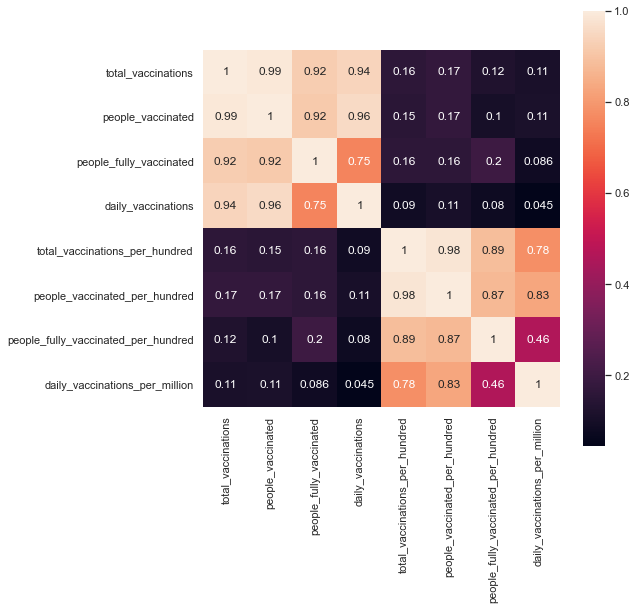

In [32]:
#heatmap for correlation of data:
plt.subplots(figsize=(8, 8))
sns.heatmap(df1.corr() , annot=True, square=True )
plt.show()

In [33]:
#check correlation of data
#sns.pairplot(data=df1);

## Feature Engineering

In [34]:
#df1['vaccines'].unique()

In [49]:
#df2[df2['country']== 'United States']

In [54]:
df2=df1.copy()
#df2 = df1.drop('vaccines', axis=1).join(df['vaccines'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True).rename('vaccines'))
df3 = df2[['country', 'date', 'vaccines']]
df3.head()

,country,date,vaccines
1,Afghanistan,2021-02-23,Oxford/AstraZeneca
2,Afghanistan,2021-02-24,Oxford/AstraZeneca
3,Afghanistan,2021-02-25,Oxford/AstraZeneca
4,Afghanistan,2021-02-26,Oxford/AstraZeneca
5,Afghanistan,2021-02-27,Oxford/AstraZeneca


In [56]:
#löschen und keine Vereinzelung der Vaccine machen?
#df4 = df3.pivot(index=['country', 'date'], columns='vaccines', values='vaccines').reset_index()
#df4.sample(5)

vaccines,country,date,"Covaxin, Oxford/AstraZeneca","EpiVacCorona, Sputnik V",Johnson&Johnson,"Johnson&Johnson, Moderna, Pfizer/BioNTech",Moderna,"Moderna, Oxford/AstraZeneca","Moderna, Oxford/AstraZeneca, Pfizer/BioNTech","Moderna, Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm/Beijing, Sputnik V",...,"Oxford/AstraZeneca, Sinovac",Pfizer/BioNTech,"Pfizer/BioNTech, Sinopharm/Beijing","Pfizer/BioNTech, Sinovac","Pfizer/BioNTech, Sputnik V",Sinopharm/Beijing,"Sinopharm/Beijing, Sinopharm/Wuhan, Sinovac","Sinopharm/Beijing, Sputnik V",Sinovac,Sputnik V
4472,Malta,2021-02-19,NaN,NaN,NaN,NaN,NaN,NaN,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1251,Canada,2021-01-26,NaN,NaN,NaN,NaN,NaN,NaN,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
139,Andorra,2021-02-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Pfizer/BioNTech,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5568,Portugal,2021-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2061,Dominica,2021-02-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
#lst_ = ['country', 'date', 'vaccines']
#df1.drop(lst_, 1, inplace=True)
#df1.head(3)

,iso_code,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million
1,AFG,NaN,NaN,0.0,1367.0,NaN,NaN,0.0,35.0
2,AFG,NaN,NaN,0.0,1367.0,NaN,NaN,0.0,35.0
3,AFG,NaN,NaN,0.0,1367.0,NaN,NaN,0.0,35.0


In [58]:
#df5 = df4.join(df1)
#df5.head(3)

,country,date,"Covaxin, Oxford/AstraZeneca","EpiVacCorona, Sputnik V",Johnson&Johnson,"Johnson&Johnson, Moderna, Pfizer/BioNTech",Moderna,"Moderna, Oxford/AstraZeneca","Moderna, Oxford/AstraZeneca, Pfizer/BioNTech","Moderna, Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm/Beijing, Sputnik V",...,Sputnik V,iso_code,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million
0,Afghanistan,2021-02-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,2021-02-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,AFG,NaN,NaN,0.0,1367.0,NaN,NaN,0.0,35.0
2,Afghanistan,2021-02-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,AFG,NaN,NaN,0.0,1367.0,NaN,NaN,0.0,35.0


In [59]:
#Change NaN in vaccine columns to 0:
#df5['Covaxin'] = df5['Covaxin'].fillna(0)
#df5['EpiVacCorona'] = df5['EpiVacCorona'].fillna(0)
#df5['Johnson&Johnson'] = df5['Johnson&Johnson'].fillna(0)
#df5['Moderna'] = df5['Moderna'].fillna(0)
#df5['Oxford/AstraZeneca'] = df5['Oxford/AstraZeneca'].fillna(0)
#df5['Pfizer/BioNTech'] = df5['Pfizer/BioNTech'].fillna(0)
#df5['Sinopharm/Beijing'] = df5['Sinopharm/Beijing'].fillna(0)
#df5['Sinopharm/Wuhan'] = df5['Sinopharm/Wuhan'].fillna(0)
#df5['Sinovac'] = df5['Sinovac'].fillna(0)
#df5['Sputnik V'] = df5['Sputnik V'].fillna(0)

KeyError: 'Covaxin'

In [90]:
#vaccine_repl(df5)
#df5.sample(5)

,country,date,"Covaxin, Oxford/AstraZeneca","EpiVacCorona, Sputnik V",Johnson&Johnson,"Johnson&Johnson, Moderna, Pfizer/BioNTech",Moderna,"Moderna, Oxford/AstraZeneca","Moderna, Oxford/AstraZeneca, Pfizer/BioNTech","Moderna, Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm/Beijing, Sputnik V",...,Sputnik V,iso_code,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million
2992,Honduras,2021-03-14,NaN,NaN,NaN,NaN,NaN,"Moderna, Oxford/AstraZeneca",NaN,NaN,...,NaN,GRL,NaN,NaN,0.0,77.0,NaN,NaN,0.0,1356.0
3642,Italy,2021-01-30,NaN,NaN,NaN,NaN,NaN,NaN,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",NaN,...,NaN,IMN,NaN,NaN,0.0,533.0,NaN,NaN,0.0,6268.0
1597,Colombia,2021-03-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,CHN,NaN,NaN,0.0,631579.0,NaN,NaN,0.0,439.0
412,Austria,2021-02-05,NaN,NaN,NaN,NaN,NaN,NaN,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",NaN,...,NaN,AUT,98825.0,98822.0,3.0,10735.0,1.10,1.1,0.0,1192.0
4629,Moldova,2021-03-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,MDV,98311.0,NaN,0.0,4895.0,18.19,NaN,0.0,9056.0


In [92]:
#Change vaccine names to 1:
#df5['Covaxin'] = df5['Covaxin'].replace(['Covaxin'],1)
#df5['EpiVacCorona'] = df5['EpiVacCorona'].replace(['EpiVacCorona'],1)
#df5['Johnson&Johnson'] = df5['Johnson&Johnson'].replace(['Johnson&Johnson'],1)
#df5['Moderna'] = df5['Moderna'].replace(['Moderna'],1)
#df5['Oxford/AstraZeneca'] = df5['Oxford/AstraZeneca'].replace(['Oxford/AstraZeneca'],1)

#df5['Pfizer/BioNTech'] = df5['Pfizer/BioNTech'].replace(['Pfizer/BioNTech'],1)
#df5['Sinopharm/Beijing'] = df5['Sinopharm/Beijing'].replace(['Sinopharm/Beijing'],1)
#df5['Sinopharm/Wuhan'] = df5['Sinopharm/Wuhan'].replace(['Sinopharm/Wuhan'],1)
#df5['Sinovac'] = df5['Sinovac'].replace(['Sinovac'],1)
#df5['Sputnik V'] = df5['Sputnik V'].replace(['Sputnik V'],1)

In [93]:
#Number of countries included in dataset:
df6 = df5.copy()
df6 = df6.set_index(['date'])
ncountry = df6['country'].nunique()
print(F'{ncountry} countries are included in the Covid-19 vaccination progress dataset.')

144 countries are included in the Covid-19 vaccination progress dataset.


In [94]:
#Create list with countries per region, create new column in df6 and map region to country:
Africa = ('Algeria','Angola','Chad', "Cote d'Ivoire",'Egypt','Equatorial Guinea','Ghana','Guinea','Kenya','Malawi','Maldives','Mali','Mauritius','Morocco','Mozambique','Namibia','Niger','Nigeria','Rwanda','Sao Tome and Principe', 'Senegal','Seychelles','Sierra Leone','Somalia','South Africa','South Sudan','Sudan','Swaziland','Tanzania','Togo','Tunisia','Uganda','Western Sahara', 'Zambia','Zimbabwe')

Asia = ('Afghanistan','Azerbaijan','Bangladesh','Bhutan','Brunei','Cambodia','China','East Timor','Hong Kong','India','Indonesia','Japan','Kazakhstan','Kyrgyzstan','Laos','Macao','Malaysia','Maldives','Mongolia','Myanmar','Nepal','North Korea','Pakistan','Philippines','Russia','Singapore','South Korea','Sri Lanka','Taiwan','Tajikistan','Thailand','Turkmenistan','Uzbekistan','Vietnam')
    
Middle_East = ('Bahrain','Iran','Iraq','Israel','Jordan','Kuwait','Lebanon','Oman','Qatar','Saudi Arabia','Syria','Turkey','United Arab Emirates','Yemen')
   
Europe = ('Albania','Andorra','Armenia','Austria','Belarus','Belgium','Bosnia and Herzegovina','Bulgaria','Croatia','Cyprus','Czechia','Denmark','Estonia','Faeroe Islands','Finland','France','Georgia','Germany','Greece','Greenland','Hungary','Iceland','Ireland','Italy','Latvia','Liechtenstein','Lithuania','Luxembourg','Macedonia','Malta','Moldova','Monaco','Montenegro','Netherlands','North Macedonia','Northern Cyprus','Norway','Poland','Portugal','Romania','San Marino','Serbia','Slovakia','Slovenia','Spain','Sweden','Switzerland','Ukraine','Vatican City')

UK_BritishOversea= ('United Kingdom','Anguilla','Antigua and Barbuda','Bermuda','Cayman Islands','Falkland Islands','Gibraltar','Guernsey','Isle of Man','Jersey', 'Montserrat', 'Saint Helena', 'Turks and Caicos Islands')

North_America = ('Canada','United States')
Central_America_Caribic = ('Antigua and Barbuda','Bahamas','Barbados','Belize','Costa Rica','Cuba','Dominica','Dominican Republic','El Salvador','Grenada','Guatemala','Haiti','Honduras','Jamaica','Mexico','Nicaragua','Panama','Saint Kitts and Nevis','Saint Lucia','Saint Vincent and the Grenadines','Trinidad and Tobago')
South_America = ('Argentina','Bolivia','Brazil','Chile','Colombia','Ecuador','Guyana','Paraguay','Peru','Suriname','Uruguay','Venezuela')
Australia_Oceania = ('Australia','Fiji','Kiribati','Marshall Islands','Micronesia','Nauru','New Zealand','Palau','Papua New Guinea','Samoa','Solomon Islands','Tonga','Tuvalu','Vanuatu')


continents = {country: 'Asia' for country in Asia}
continents.update({country: 'Europe' for country in Europe})
continents.update({country: 'Africa' for country in Africa})
continents.update({country: 'Middle_East' for country in Middle_East})
continents.update({country: 'UK_BritishOversea' for country in UK_BritishOversea})
continents.update({country: 'North_America' for country in North_America})
continents.update({country: 'Central_America_Caribic' for country in Central_America_Caribic})
continents.update({country: 'South_America' for country in South_America})
continents.update({country: 'Australia_Oceania' for country in Australia_Oceania})

df6['cgrouped'] = df6['country'].map(continents)



In [95]:
#Save cleaned and feature engineered dataframes as csv files to upload to EDA Notebook:
df2.to_csv('df2.csv', encoding='utf-8', index=False)
df3.to_csv('df3.csv', encoding='utf-8', index=False)
df4.to_csv('df4.csv', encoding='utf-8', index=False)
df5.to_csv('df5.csv', encoding='utf-8', index=False)
df6.to_csv('df6.csv', encoding='utf-8', index=False)

Merge:

In [96]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7497 entries, 1 to 8078
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   country                              7497 non-null   object        
 1   iso_code                             7497 non-null   object        
 2   date                                 7497 non-null   datetime64[ns]
 3   total_vaccinations                   4523 non-null   float64       
 4   people_vaccinated                    3983 non-null   float64       
 5   people_fully_vaccinated              7497 non-null   float64       
 6   daily_vaccinations                   7491 non-null   float64       
 7   total_vaccinations_per_hundred       4523 non-null   float64       
 8   people_vaccinated_per_hundred        3983 non-null   float64       
 9   people_fully_vaccinated_per_hundred  7497 non-null   float64       
 10  daily_vaccin

In [97]:
df2[df2['country']== 'United States']

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines
7789,United States,USA,2020-12-21,614117.0,614117.0,0.0,57909.0,0.18,0.18,0.00,173.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"
7790,United States,USA,2020-12-22,NaN,NaN,0.0,127432.0,NaN,NaN,0.00,381.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"
7791,United States,USA,2020-12-23,1008025.0,1008025.0,0.0,150606.0,0.30,0.30,0.00,450.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"
7792,United States,USA,2020-12-24,NaN,NaN,0.0,191001.0,NaN,NaN,0.00,571.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"
7793,United States,USA,2020-12-25,NaN,NaN,0.0,215238.0,NaN,NaN,0.00,644.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"
...,...,...,...,...,...,...,...,...,...,...,...,...
7878,United States,USA,2021-03-20,121441497.0,79367225.0,43036818.0,2248285.0,36.31,23.73,12.87,6723.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"
7879,United States,USA,2021-03-21,124481412.0,81415769.0,44141228.0,2488734.0,37.22,24.34,13.20,7441.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"
7880,United States,USA,2021-03-22,126509736.0,82772416.0,44910946.0,2489697.0,37.83,24.75,13.43,7444.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"
7881,United States,USA,2021-03-23,128217029.0,83930495.0,45533962.0,2497025.0,38.34,25.10,13.61,7466.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"


## Adding information to our dataset

The original Kaggle dataset about vaccination progress only includes information around counts of vaccinations or people vaccinated. For getting a deeper insight what supports a fast vaccination progress we add information about infections, deaths, population and gdp per capita and merge these with out dataset.

In [98]:
# load of additional dataset(cleaned in covid19_additional_info):
df_owid_covid_23march_1 = pd.read_csv('df_owid_covid_23march_1.csv')
df_owid_covid_23march_1.head()

,iso_code,country,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,new_deaths_smoothed_per_million,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Afghanistan,2020-02-24,1.0,1.0,0.0,0.0,0.0,0.0,0.026,...,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,0.5,64.83,0.511
1,AFG,Afghanistan,2020-02-25,1.0,0.0,0.0,0.0,0.0,0.0,0.026,...,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,0.5,64.83,0.511
2,AFG,Afghanistan,2020-02-26,1.0,0.0,0.0,0.0,0.0,0.0,0.026,...,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,0.5,64.83,0.511
3,AFG,Afghanistan,2020-02-27,1.0,0.0,0.0,0.0,0.0,0.0,0.026,...,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,0.5,64.83,0.511
4,AFG,Afghanistan,2020-02-28,1.0,0.0,0.0,0.0,0.0,0.0,0.026,...,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,0.5,64.83,0.511


In [99]:
#Information about datatypes per column:
df_owid_covid_23march_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75099 entries, 0 to 75098
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   iso_code                         75099 non-null  object 
 1   country                          75099 non-null  object 
 2   date                             75099 non-null  object 
 3   total_cases                      75099 non-null  float64
 4   new_cases                        75092 non-null  float64
 5   new_cases_smoothed               75099 non-null  float64
 6   total_deaths                     75099 non-null  float64
 7   new_deaths                       75099 non-null  float64
 8   new_deaths_smoothed              75099 non-null  float64
 9   total_cases_per_million          75099 non-null  float64
 10  new_cases_per_million            75092 non-null  float64
 11  new_cases_smoothed_per_million   75099 non-null  float64
 12  total_deaths_per_m

- Missing information for population density, median_age, aged_65_older, aged_70_older, gdp_per_capita, hospital_bed_per_thousand, life_expectancy, human_development_index

- For further use only population density and gp_per_capita is important. Therefor we drop the other columns. For population density and gdp_per_capita the missing data can be find and has to be added.

- Change type to datetime for column date.

In [100]:
#Change data type to datetime:
df_owid_covid_23march_1['date'] = pd.to_datetime(df_owid_covid_23march_1['date'])
df2['date'] = pd.to_datetime(df2['date'])

In [101]:
#Combine dataset with pd.merge:
df_all = pd.merge(df2, df_owid_covid_23march_1, on='iso_code', how='right')

In [102]:
merge_df = pd.merge(df2, df_owid_covid_23march_1)#,left_on='date', right_on='country'

In [103]:
df_all.tail()

,country_x,iso_code,date_x,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,...,new_deaths_smoothed_per_million,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,hospital_beds_per_thousand,life_expectancy,human_development_index
2685950,Zimbabwe,ZWE,2021-03-20,42210.0,42210.0,0.0,836.0,0.28,0.28,0.0,...,0.087,14862927.0,42.729,19.6,2.822,1.882,1899.775,1.7,61.49,0.571
2685951,Zimbabwe,ZWE,2021-03-21,42729.0,42729.0,0.0,910.0,0.29,0.29,0.0,...,0.087,14862927.0,42.729,19.6,2.822,1.882,1899.775,1.7,61.49,0.571
2685952,Zimbabwe,ZWE,2021-03-22,43294.0,43294.0,0.0,805.0,0.29,0.29,0.0,...,0.087,14862927.0,42.729,19.6,2.822,1.882,1899.775,1.7,61.49,0.571
2685953,Zimbabwe,ZWE,2021-03-23,44135.0,44135.0,0.0,655.0,0.30,0.30,0.0,...,0.087,14862927.0,42.729,19.6,2.822,1.882,1899.775,1.7,61.49,0.571
2685954,Zimbabwe,ZWE,2021-03-24,49404.0,49404.0,0.0,1400.0,0.33,0.33,0.0,...,0.087,14862927.0,42.729,19.6,2.822,1.882,1899.775,1.7,61.49,0.571


In [104]:
#merge noch prüfen und evtl korrigieren

In [105]:
#df_all_date = df_all[['country_x', 'country_y', 'date_x', 'date_y']]
#df_all_date.head()

In [106]:
df_for_model = merge_df[['country', 'iso_code', 'date', 'daily_vaccinations', 'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred', 'population', 'population_density', 'gdp_per_capita']]
df_for_model.head()
df_for_model.to_csv('df_for_model.csv', encoding='utf-8', index=False)

In [107]:
#merge_df.sample()

In [108]:
#df_all[df_all['country_x']== 'United States']

In [109]:
df2[df2['country']== 'United States']

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines
7789,United States,USA,2020-12-21,614117.0,614117.0,0.0,57909.0,0.18,0.18,0.00,173.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"
7790,United States,USA,2020-12-22,NaN,NaN,0.0,127432.0,NaN,NaN,0.00,381.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"
7791,United States,USA,2020-12-23,1008025.0,1008025.0,0.0,150606.0,0.30,0.30,0.00,450.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"
7792,United States,USA,2020-12-24,NaN,NaN,0.0,191001.0,NaN,NaN,0.00,571.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"
7793,United States,USA,2020-12-25,NaN,NaN,0.0,215238.0,NaN,NaN,0.00,644.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"
...,...,...,...,...,...,...,...,...,...,...,...,...
7878,United States,USA,2021-03-20,121441497.0,79367225.0,43036818.0,2248285.0,36.31,23.73,12.87,6723.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"
7879,United States,USA,2021-03-21,124481412.0,81415769.0,44141228.0,2488734.0,37.22,24.34,13.20,7441.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"
7880,United States,USA,2021-03-22,126509736.0,82772416.0,44910946.0,2489697.0,37.83,24.75,13.43,7444.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"
7881,United States,USA,2021-03-23,128217029.0,83930495.0,45533962.0,2497025.0,38.34,25.10,13.61,7466.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"


In [110]:
#check if merge is correct:
df_all[df_all['country_x']== 'United States']

,country_x,iso_code,date_x,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,...,new_deaths_smoothed_per_million,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,hospital_beds_per_thousand,life_expectancy,human_development_index
2609343,United States,USA,2020-12-21,614117.0,614117.0,0.0,57909.0,0.18,0.18,0.00,...,0.000,331002647.0,35.608,38.3,15.413,9.732,54225.446,2.77,78.86,0.926
2609344,United States,USA,2020-12-22,NaN,NaN,0.0,127432.0,NaN,NaN,0.00,...,0.000,331002647.0,35.608,38.3,15.413,9.732,54225.446,2.77,78.86,0.926
2609345,United States,USA,2020-12-23,1008025.0,1008025.0,0.0,150606.0,0.30,0.30,0.00,...,0.000,331002647.0,35.608,38.3,15.413,9.732,54225.446,2.77,78.86,0.926
2609346,United States,USA,2020-12-24,NaN,NaN,0.0,191001.0,NaN,NaN,0.00,...,0.000,331002647.0,35.608,38.3,15.413,9.732,54225.446,2.77,78.86,0.926
2609347,United States,USA,2020-12-25,NaN,NaN,0.0,215238.0,NaN,NaN,0.00,...,0.000,331002647.0,35.608,38.3,15.413,9.732,54225.446,2.77,78.86,0.926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2649476,United States,USA,2021-03-20,121441497.0,79367225.0,43036818.0,2248285.0,36.31,23.73,12.87,...,2.884,331002647.0,35.608,38.3,15.413,9.732,54225.446,2.77,78.86,0.926
2649477,United States,USA,2021-03-21,124481412.0,81415769.0,44141228.0,2488734.0,37.22,24.34,13.20,...,2.884,331002647.0,35.608,38.3,15.413,9.732,54225.446,2.77,78.86,0.926
2649478,United States,USA,2021-03-22,126509736.0,82772416.0,44910946.0,2489697.0,37.83,24.75,13.43,...,2.884,331002647.0,35.608,38.3,15.413,9.732,54225.446,2.77,78.86,0.926
2649479,United States,USA,2021-03-23,128217029.0,83930495.0,45533962.0,2497025.0,38.34,25.10,13.61,...,2.884,331002647.0,35.608,38.3,15.413,9.732,54225.446,2.77,78.86,0.926


In [111]:
#merge_df.to_csv('merge_df.csv', encoding='utf-8', index=False)

In [112]:
#Feature Engeenering for province data and longitudes/latitudes

In [113]:
#import dataframe with country information and longitudes/latitudes
df_coordinates_wo_Province = pd.read_csv('coordinates_wo_Province.csv')

In [114]:
df_coordinates_wo_Province.shape

(950670, 4)

In [115]:
df2_for_merge = df2[['country', 'iso_code']].copy()

In [116]:
#add latitude/longitude data to dataframe for worldmap plotting:


df2_with_coordinates_wo_Province = pd.merge(df2_for_merge, df_coordinates_wo_Province, on='iso_code', how='right')#, left_on='iso_code', right_on='country'

In [117]:
df2_with_coordinates_wo_Province.sample(10)

,country_x,iso_code,country_y,Lat,Long
1469220,Argentina,ARG,Argentina,-38.416100,-63.616700
68009045,United States,USA,US,39.691163,-83.890321
80479728,United States,USA,US,38.892851,-80.236891
8580857,United States,USA,US,39.564536,-77.023737
66160849,United States,USA,US,44.405558,-95.252070
8705065,United States,USA,US,34.576921,-93.149216
27373411,United States,USA,US,31.922896,-83.768118
14847544,United States,USA,US,34.152724,-82.127158
1446821,China,CHN,China,39.305400,117.323000
24625135,United States,USA,US,30.934648,-84.868239


In [118]:
df2_with_coordinates_wo_Province.sample(10)

,country_x,iso_code,country_y,Lat,Long
69274236,United States,USA,US,47.038928,-122.140596
21302895,United States,USA,US,40.421627,-77.976733
78377004,United States,USA,US,44.042010,-75.946535
59724767,United States,USA,US,36.208413,-81.162329
71609802,United States,USA,US,32.971951,-94.977901
1697380,Peru,PER,Peru,-9.190000,-75.015200
56406753,United States,USA,US,39.742025,-84.647870
66470403,United States,USA,US,NaN,NaN
5982500,United States,USA,US,37.317289,-91.965647
13410799,United States,USA,US,33.543380,-81.636454


In [119]:
df2_with_coordinates_wo_Province[df2_with_coordinates_wo_Province.iso_code == 'BEL']

,country_x,iso_code,country_y,Lat,Long
15614,Belgium,BEL,Belgium,50.8333,4.469936
15615,Belgium,BEL,Belgium,50.8333,4.469936
15616,Belgium,BEL,Belgium,50.8333,4.469936
15617,Belgium,BEL,Belgium,50.8333,4.469936
15618,Belgium,BEL,Belgium,50.8333,4.469936
...,...,...,...,...,...
85681082,Belgium,BEL,Belgium,50.8333,4.469936
85681083,Belgium,BEL,Belgium,50.8333,4.469936
85681084,Belgium,BEL,Belgium,50.8333,4.469936
85681085,Belgium,BEL,Belgium,50.8333,4.469936


In [120]:
df_coordinate_Province = pd.read_csv('coordinates.csv')
df_coordinate_Province.tail()

,country,Province_State,iso_code,Lat,Long
950665,US,Montana,USA,47.037286,-113.921351
950666,US,Michigan,USA,46.665226,-89.313905
950667,US,North Dakota,USA,46.108304,-97.632172
950668,US,Kentucky,USA,37.477518,-86.853681
950669,US,Mississippi,USA,31.231326,-89.820922


In [121]:

df2_coordinates_Province = pd.merge(df2_for_merge, df_coordinate_Province, on='iso_code', how='right')

In [122]:
df2_coordinates_Province.head()

,country_x,iso_code,country_y,Province_State,Lat,Long
0,NaN,ESH,Western Sahara,NaN,24.2155,-12.8858
1,Switzerland,CHE,Switzerland,NaN,46.8182,8.2275
2,Switzerland,CHE,Switzerland,NaN,46.8182,8.2275
3,Switzerland,CHE,Switzerland,NaN,46.8182,8.2275
4,Switzerland,CHE,Switzerland,NaN,46.8182,8.2275


In [123]:
df2_coordinates_Province[df2_coordinates_Province.country_x == 'China'].head

<bound method NDFrame.head of          country_x iso_code country_y Province_State      Lat      Long
595          China      CHN     China          Tibet  31.6927   88.0924
596          China      CHN     China          Tibet  31.6927   88.0924
597          China      CHN     China          Tibet  31.6927   88.0924
598          China      CHN     China          Tibet  31.6927   88.0924
599          China      CHN     China          Tibet  31.6927   88.0924
...            ...      ...       ...            ...      ...       ...
85713428     China      CHN     China         Shanxi  37.5777  112.2922
85713429     China      CHN     China         Shanxi  37.5777  112.2922
85713430     China      CHN     China         Shanxi  37.5777  112.2922
85713431     China      CHN     China         Shanxi  37.5777  112.2922
85713432     China      CHN     China         Shanxi  37.5777  112.2922

[820260 rows x 6 columns]>

In [124]:
df2_coordinates_Province.shape

(85723110, 6)

In [125]:

#df2_with_coordinates_concat = pd.concat([df2_for_merge, df_coordinates_wo_Province], keys='iso_code')

In [126]:
df2_with_coordinates_wo_Province.sample(10)

,country_x,iso_code,country_y,Lat,Long
46552188,United States,USA,US,33.079437,-80.405027
60415508,United States,USA,US,34.838630,-79.475798
45082208,United States,USA,US,38.214503,-92.426109
36482896,United States,USA,US,41.723306,-111.744367
61501241,United States,USA,US,32.431720,-81.024875
38946551,United States,USA,US,39.823046,-85.775664
81310792,United States,USA,US,40.729342,-85.221330
40544259,United States,USA,US,33.960442,-84.021378
43764778,United States,USA,US,31.195766,-81.977440
67797844,United States,USA,US,43.002260,-78.191352


In [127]:
df2_with_coordinates_wo_Province.sample(10)

,country_x,iso_code,country_y,Lat,Long
41815748,United States,USA,US,45.900189,-112.662009
22747103,United States,USA,US,43.082472,-95.150965
6124000,United States,USA,US,41.642322,-85.426742
77375923,United States,USA,US,32.739971,-99.878616
53203456,United States,USA,US,33.179067,-100.253840
16785332,United States,USA,US,38.696777,-98.204628
77051055,United States,USA,US,37.885830,-95.300308
5102742,United States,USA,US,39.889545,-74.280893
58985311,United States,USA,US,NaN,NaN
71547247,United States,USA,US,36.170074,-86.786461


In [128]:
df2_with_coordinates_wo_Province[df2_with_coordinates_wo_Province.iso_code == 'DEU']

,country_x,iso_code,country_y,Lat,Long
3418,Germany,DEU,Germany,51.165691,10.451526
3419,Germany,DEU,Germany,51.165691,10.451526
3420,Germany,DEU,Germany,51.165691,10.451526
3421,Germany,DEU,Germany,51.165691,10.451526
3422,Germany,DEU,Germany,51.165691,10.451526
...,...,...,...,...,...
83674312,Germany,DEU,Germany,51.165691,10.451526
83674313,Germany,DEU,Germany,51.165691,10.451526
83674314,Germany,DEU,Germany,51.165691,10.451526
83674315,Germany,DEU,Germany,51.165691,10.451526
